In [ ]:
import os
import warnings
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")

# Function to load data from directory
def load_data(directory):
    file_paths = []
    labels = []
    class_folders = os.listdir(directory)
    for class_folder in class_folders:
        class_folder_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_folder_path):
            files = os.listdir(class_folder_path)
            for file in files:
                file_paths.append(os.path.join(class_folder_path, file))
                labels.append(class_folder)
    return pd.DataFrame({"file_path": file_paths, "label": labels})

# Load original dataset
main_dir_path = "./dataset_split2/"
file_paths = []
labels = []
folders = os.listdir(main_dir_path)

for subfolder in ["test", "train", "val"]:
    subfolder_path = os.path.join(main_dir_path, subfolder)
    class_folders = os.listdir(subfolder_path)
    for class_folder in class_folders:
        class_folder_path = os.path.join(subfolder_path, class_folder)
        files = os.listdir(class_folder_path)
        for file in files:
            file_paths.append(os.path.join(class_folder_path, file))
            labels.append(class_folder)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Balance dataset
class_counts = df["label"].value_counts()
print("Class Distribution Before Balancing:\n", class_counts)
min_samples = class_counts.min()
balanced_df = df.groupby("label").apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop= True)
print("Class Distribution After Balancing:\n", balanced_df["label"].value_counts())

# Split dataset
train_df, tv_df = train_test_split(balanced_df, test_size=0.2, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(tv_df, test_size=0.5, shuffle=True, random_state=42)

# Define constants
K = df.label.nunique()
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
TRAIN_VALID_BATCH_SIZE = 32
test_length = len(test_df)
TEST_BATCH_SIZE = max(sorted([test_length // n for n in range(1, test_length + 1) if test_length % n == 0 and test_length / n <= 80]))

# Data augmentation
gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

train_gen = gen.flow_from_dataframe(
    train_df, x_col="file_path", y_col="label", shuffle=True, target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE, class_mode='categorical'
)
valid_gen = gen.flow_from_dataframe(
    valid_df, x_col="file_path", y_col="label", shuffle=True, target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE, class_mode='categorical'
)
test_gen = gen.flow_from_dataframe(
    test_df, x_col="file_path", y_col="label", shuffle=False, target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE, class_mode='categorical'
)

# Build model
base_model = DenseNet121(input_shape=IMG_SHAPE, weights="imagenet", include_top=False)
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(K, activation="softmax")
])

# Compile and train
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

r = model.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=callbacks, shuffle=False)

# Plot training history
tr_acc = r.history['accuracy']
tr_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']
best_loss_index = np.argmin(val_loss)
val_lowest = val_loss[best_loss_index]
best_train_acc_index = np.argmax(val_acc)
acc_highest = val_acc[best_train_acc_index]
epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(best_loss_index + 1)}'
acc_label = f'best epoch= {str(best_train_acc_index + 1)}'

plt.figure(figsize=(10, 4))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.scatter(best_loss_index + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(best_train_acc_index + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.show()

# Load and test new dataset
new_test_dir = "./balanced2"
new_test_df = load_data(new_test_dir)
new_test_df['hash'] = new_test_df['file_path'].apply(lambda x: hashlib.md5(open(x, 'rb').read()).hexdigest())
print("Number of duplicates in new test data:", new_test_df['hash'].duplicated().sum())
new_test_df = new_test_df.drop_duplicates(subset='hash').drop(columns='hash')
print("New Test Data Class Distribution:\n", new_test_df["label"].value_counts())

if set(new_test_df['label'].unique()) != set(train_gen.class_indices.keys()):
    raise ValueError("Class labels in new test data do not match training data classes.")

new_test_gen = gen.flow_from_dataframe(
    new_test_df, x_col="file_path", y_col="label", target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE, class_mode="categorical", shuffle=False, seed=42
)

new_test_length = len(new_test_df)
new_test_steps = ceil(new_test_length / TEST_BATCH_SIZE)
new_test_score = model.evaluate(new_test_gen, steps=new_test_steps)
print(f"New Test Loss: {new_test_score[0]:.6f}")
print(f"New Test Accuracy: {round(new_test_score[1]*100)}%")

y_pred_new = np.argmax(model.predict(new_test_gen, steps=new_test_steps), axis=1)
y_true_new = new_test_gen.classes
cm_new = confusion_matrix(y_true_new, y_pred_new)
disp_new = ConfusionMatrixDisplay(cm_new, display_labels=list(new_test_gen.class_indices.keys()))

plt.figure(figsize=(6, 5))
ax = plt.gca()  # Get current axes
disp_new.plot(cmap="Blues", xticks_rotation=45, ax=ax)
ax.grid(False)  # Disable grid
plt.title("Confusion Matrix - New Test Data")
plt.show()


print("\nClassification Report - New Test Data:")
print(classification_report(y_true_new, y_pred_new, target_names=list(new_test_gen.class_indices.keys())))

# Test original test data
# test_steps = ceil(test_length / TEST_BATCH_SIZE)
# test_score = model.evaluate(test_gen, steps=test_steps)
# print(f"Original Test Loss: {test_score[0]:.6f}")
# print(f"Original Test Accuracy: {round(test_score[1]*100)}%")

# Yhat = np.argmax(model.predict(test_gen, steps=test_steps), axis=1)
# Ytrue = test_gen.classes
# cm = confusion_matrix(Ytrue, Yhat)
# disp = ConfusionMatrixDisplay AscentDisplay(cm, display_labels=list(test_gen.class_indices.keys()))

# fig, ax = plt.subplots(figsize=(10, 8))
# disp.plot(cmap="Blues", ax=ax)
# ax.grid(False)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.title("Confusion Matrix - Original Test Data")
# plt.show()

# print("\nClassification Report - Original Test Data:")
print(classification_report(Ytrue, Yhat, target_names=list(test_gen.class_indices.keys())))

Class Distribution Before Balancing:
 label
Dyskeratotic                2000
Metaplastic                 2000
Koilocytotic                2000
Parabasal                   2000
Superficial-Intermediate    2000
Name: count, dtype: int64
Class Distribution After Balancing:
 label
Dyskeratotic                2000
Koilocytotic                2000
Metaplastic                 2000
Parabasal                   2000
Superficial-Intermediate    2000
Name: count, dtype: int64
Found 8000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.7729 - loss: 0.6468 - val_accuracy: 0.9510 - val_loss: 0.1207 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 230s 922ms/step - accuracy: 0.9425 - loss: 0.1638 - val_accuracy: 0.9820 - val_loss: 0.0515 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


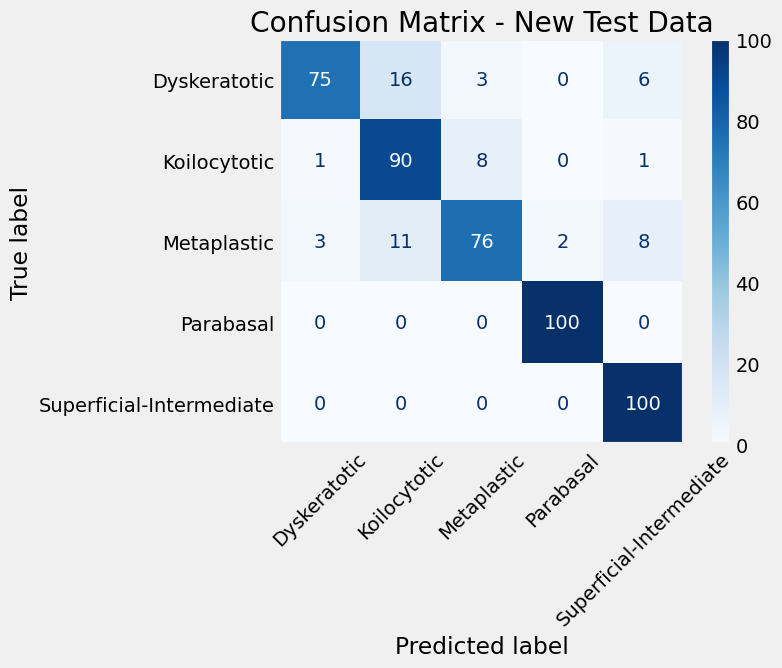


Classification Report - New Test Data:
                          precision    recall  f1-score   support

            Dyskeratotic       0.95      0.75      0.84       100
            Koilocytotic       0.77      0.90      0.83       100
             Metaplastic       0.87      0.76      0.81       100
               Parabasal       0.98      1.00      0.99       100
Superficial-Intermediate       0.87      1.00      0.93       100

                accuracy                           0.88       500
               macro avg       0.89      0.88      0.88       500
            weighted avg       0.89      0.88      0.88       500



In [4]:
# Predict and compute confusion matrix for new test data
y_pred_new = np.argmax(model.predict(new_test_gen, steps=new_test_steps), axis=1)
y_true_new = new_test_gen.classes
cm_new = confusion_matrix(y_true_new, y_pred_new)
disp_new = ConfusionMatrixDisplay(cm_new, display_labels=list(new_test_gen.class_indices.keys()))

plt.figure(figsize=(6, 5))
ax = plt.gca()  # Get current axes
disp_new.plot(cmap="Blues", xticks_rotation=45, ax=ax)
ax.grid(False)  # Disable grid
plt.title("Confusion Matrix - New Test Data")
plt.show()

print("\nClassification Report - New Test Data:")
print(classification_report(y_true_new, y_pred_new, target_names=list(new_test_gen.class_indices.keys())))